In [16]:
# necessary imports, do not change this cell
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# For colormaps
import matplotlib.cm as cm 

In [2]:
iris = load_iris()

# creating the set of datapoints in the iris dataset
iris_data = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_data_arr = iris.data

# defining euclidean distance as the distance metric to be used 

def euclidean(a, b):
    return np.sqrt(np.sum((a-b)**2))

# defining perplexity hyperparameter for performing TSNE 
perplexity = 2

In [3]:
# creating the probability distribution of data points in higher dimesion

def higher_dimension_p_ij(iris_data_arr):
    N = iris_data_arr.shape[0] # get the total number of points in the dataset
    probs_marginal_ij = [] # creating empty list for containing marginal probabilities for i and j being neighbours

    # compute conditional probs p_i|j
    for i in range(iris_data_arr.shape[0]):
        for j in range(iris_data_arr.shape[0]):
            if i==j:
                continue
            prob_numerator = np.exp(-1*(euclidean(iris_data_arr[i], iris_data_arr[j])**2)/(2*(perplexity**2)))
            
            prob_denominator_i = 0 # for point i
            prob_denominator_j = 0 # for point j
            
            for k in range(iris_data_arr.shape[0]):
                if k==i or k==j:
                    continue
                prob_denominator_i += np.exp(-1*(euclidean(iris_data_arr[i], iris_data_arr[k])**2)/(2*perplexity**2))
                prob_denominator_j += np.exp(-1*(euclidean(iris_data_arr[j], iris_data_arr[k])**2)/(2*perplexity**2))

            # computing marginal probability p_ij
            prob_ij = (prob_numerator/prob_denominator_i + prob_numerator/prob_denominator_j)/(2*N)
            probs_marginal_ij.append(prob_ij)

    return probs_marginal_ij

# compute collection of p_ij for data points i and j
higher_dim_marginal_probs = higher_dimension_p_ij(iris_data_arr)

In [4]:
# selecting k < 4 features randomly from the set of features
try:
    k = int(input("Enter how many features of iris dataset have to be preserved:-"))
    assert k < 4 and k > 0
    
    iris_random_features = np.sort(np.random.choice(np.arange(0,len(list(iris.feature_names))), size = k, replace = False))
    print(iris_random_features)
except(Exception):
    print("Exception has occured. Please try again.")

Enter how many features of iris dataset have to be preserved:- 2


[1 2]


In [5]:
# Create embedding mapping in lower dimension by placing data points randomly

iris_data_arr_reduced = iris_data_arr[:,iris_random_features]

min_max_reduced_features = []  
''' to keep in track of the minimum and maximum along each feature,
chosen to be used in lower dimension '''

for i in range(k):
    min_max_reduced_features.append([])
    # append minimum and maximum values to the recently appended empty list
    min_max_reduced_features[i].append(np.min(iris_data_arr_reduced[i]))
    min_max_reduced_features[i].append(np.max(iris_data_arr_reduced[i]))

''' place data points by creating an array of random floating point numbers in the range [min, max]
for each selected feature, using uniform distribution '''

for i in range(k):
    iris_data_arr_reduced[:,i] = np.random.uniform(min_max_reduced_features[i][0], 
                                                  min_max_reduced_features[i][1], 
                                                  size = iris_data_arr.shape[0])

In [6]:
# creating the probability distribution of data points in lower dimesion

def lower_dimension_q_ij(iris_data_arr_reduced):
    N = iris_data_arr_reduced.shape[0] # get the total number of points in the dataset
    probs_marginal_ij = [] # creating empty list for containing marginal probabilities for i and j being neighbours

    # compute conditional probs p_i|j
    for i in range(iris_data_arr_reduced.shape[0]):
        for j in range(iris_data_arr_reduced.shape[0]):
            if i==j:
                continue
            prob_numerator = (1 + euclidean(iris_data_arr_reduced[i], iris_data_arr_reduced[j])**2)**(-1)
            
            prob_denominator_i = 0 # for point i
            prob_denominator_j = 0 # for point j
            
            for k in range(iris_data_arr_reduced.shape[0]):
                if k==i or k==j:
                    continue
                prob_denominator_i += (1 + euclidean(iris_data_arr_reduced[k], iris_data_arr_reduced[i])**2)**(-1)
                prob_denominator_j += (1 + euclidean(iris_data_arr_reduced[k], iris_data_arr_reduced[j])**2)**(-1)

            # computing marginal probability p_ij
            prob_ij = (prob_numerator/prob_denominator_i + prob_numerator/prob_denominator_j)/(2*N)
            probs_marginal_ij.append(prob_ij)

    return probs_marginal_ij

# compute collection of q_ij for data points i and j
lower_dim_marginal_probs = lower_dimension_q_ij(iris_data_arr_reduced)

In [7]:
assert len(lower_dim_marginal_probs) == len(higher_dim_marginal_probs)
print("Äll going right till now!")

Äll going right till now!


In [8]:
# compute overall performance of mapping to lower embedding, using divergence measure

def compute_kl_divergence(lower_dim_marginal_probs, higher_dim_marginal_probs):
    kl_div = 0.0
    for i in range(len(higher_dim_marginal_probs)):
        kl_div += higher_dim_marginal_probs[i] * np.log2(higher_dim_marginal_probs[i]/lower_dim_marginal_probs[i])
    return kl_div

In [11]:
# Optimize KL divergence in direction of approach towards minimum, to obtain best possible mapping
# compute p_ij and q_ij while ieratively optimising loss function for TSNE mapping

def p_ij(iris_data_arr, i, j):
    prob_ij_num = np.exp(-1*(euclidean(iris_data_arr[i], iris_data_arr[j])**2)/(2*(perplexity**2)))
    prob_ij_denom = 0
    for k in range(iris_data_arr_reduced.shape[0]):
        if k==i or k==j:
            continue
        prob_ij_denom += np.exp(-1*(euclidean(iris_data_arr[i], iris_data_arr[k])**2)/(2*perplexity**2))
    return prob_ij_num/prob_ij_denom

def q_ij(iris_data_arr_reduced, i, j):
    prob_ij_num = (1 + euclidean(iris_data_arr_reduced[i], iris_data_arr_reduced[j])**2)**(-1)
    prob_ij_denom = 0
    for k in range(iris_data_arr_reduced.shape[0]):
        if k==i or k==j:
            continue
        prob_ij_denom += (1 + euclidean(iris_data_arr_reduced[k], iris_data_arr_reduced[i])**2)**(-1)
    return prob_ij_num/prob_ij_denom

In [12]:
# REFER-> https://medium.com/@sachinsoni600517/mastering-t-sne-t-distributed-stochastic-neighbor-embedding

# change these values to observe the change in training performance quality 
lr = 0.01 # define the learning rate to be used during iterative gradient descent
epochs = 10 # number of epochs iterative optimisation to occur

for e in range(epochs):
    time1 = time.time() # start timer
    for i in range(iris_data_arr_reduced.shape[0]):
        # define gradient value to be used in gradient descent 
        grad = 0
        for j in range(iris_data_arr_reduced.shape[0]):
            if j==i:
                continue
            grad += 4*(p_ij(iris_data_arr, i, j) - q_ij(iris_data_arr_reduced, i, j))*((1 + euclidean(iris_data_arr_reduced[i], iris_data_arr_reduced[j])**2)**(-1))*(iris_data_arr_reduced[i] - iris_data_arr_reduced[j])
        iris_data_arr_reduced[i] -= lr*grad # perform gradient descent optimisation
    lower_probs = lower_dimension_q_ij(iris_data_arr_reduced)
    time2 = time.time() # stop timer
    print("Epoch-> {}, KL Divergence during training: {:.10f}, Time taken-> {:.10f} seconds".format(e+1, compute_kl_divergence(lower_probs, higher_dim_marginal_probs), time2-time1))

Epoch-> 1, KL Divergence during training: 0.5312977576, Time taken-> 99.9774379730 seconds
Epoch-> 2, KL Divergence during training: 0.5305984345, Time taken-> 101.1752951145 seconds
Epoch-> 3, KL Divergence during training: 0.5299029879, Time taken-> 100.3216195107 seconds
Epoch-> 4, KL Divergence during training: 0.5292113598, Time taken-> 101.8276889324 seconds
Epoch-> 5, KL Divergence during training: 0.5285234922, Time taken-> 99.6113054752 seconds
Epoch-> 6, KL Divergence during training: 0.5278393267, Time taken-> 100.5834710598 seconds
Epoch-> 7, KL Divergence during training: 0.5271588048, Time taken-> 102.0497314930 seconds
Epoch-> 8, KL Divergence during training: 0.5264818673, Time taken-> 100.0385444164 seconds
Epoch-> 9, KL Divergence during training: 0.5258084550, Time taken-> 100.0091309547 seconds
Epoch-> 10, KL Divergence during training: 0.5251385084, Time taken-> 100.0386197567 seconds


In [13]:
# computes and displays the final kl divergence across the mapping
accuracy_embedding_random = compute_kl_divergence(lower_dimension_q_ij(iris_data_arr_reduced), higher_dim_marginal_probs)

print("KL Divergence for TSNE mapping, after iterative optimisation, is {:.10f}".format(accuracy_embedding_random))

KL Divergence for TSNE mapping, after iterative optimisation, is 0.5251385084


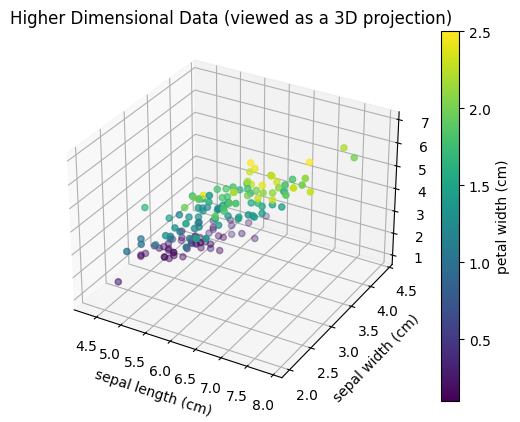

Text(0.5, 1.0, 'Lower Dimensional Data (as ascertained by performing t-SNE algorithm)')

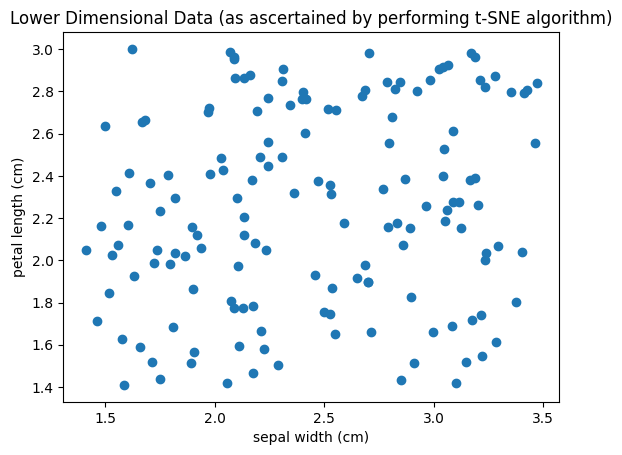

In [37]:
# plotting the results

# plot higher dimensional data
x = iris_data_arr[:, 0]
y = iris_data_arr[:, 1]
z = iris_data_arr[:, 2]
w = iris_data_arr[:, 3] # fourth dimension

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color mapping
scatter = ax.scatter(x, y, z, c = w, cmap = cm.viridis) # 'c=w' maps w to colors

# Add a colorbar to interpret the color mapping
fig.colorbar(scatter, label=list(iris.feature_names)[-1])

ax.set_xlabel(list(iris.feature_names)[0])
ax.set_ylabel(list(iris.feature_names)[1])
ax.set_zlabel(list(iris.feature_names)[2])
plt.title('Higher Dimensional Data (viewed as a 3D projection)')
plt.show()

# plot lower dimensional data, as determined by t-SNE
x = iris_data_arr_reduced[:, 0]
y = iris_data_arr_reduced[:, 1]

# iris_random_features, list(iris.feature_names)
plt.scatter(x, y)
plt.xlabel(list(iris.feature_names)[iris_random_features[0]])
plt.ylabel(list(iris.feature_names)[iris_random_features[1]])
plt.title('Lower Dimensional Data (as ascertained by performing t-SNE algorithm)')